In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import intersect1d, setdiff1d, quantile, unique, asarray, zeros
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
from copy import deepcopy


from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson
import scipy.sparse as sp
from scipy.io import mmread
from scipy.stats import pearsonr

from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import seaborn as sns
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available


import importlib

import sys
import umap
from fuzzywuzzy import process



/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import seaborn as sns
import pandas as pd
import importlib

import numpy as np
from numpy import intersect1d, setdiff1d, quantile, unique, asarray, zeros
from matplotlib import pyplot
import matplotlib.pyplot as plt

import sys
import umap
from fuzzywuzzy import process


In [3]:
# Add the src directory to the Python path
sys.path.append(os.path.abspath('/home/nandivada.s/genoTopheno/src'))

# Import the sciPENN_API module


import sciPENN.sciPENN_API
import sciPENN.Preprocessing

# Reload the module to ensure the latest changes are reflected
# importlib.reload(SCIPENN.sciPENN_API)

from sciPENN.sciPENN_API import sciPENN_API
from sciPENN.Preprocessing import preprocess


In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [5]:
from sciPENN.Utils import build_dir
from sciPENN.Preprocessing import preprocess
from sciPENN.Data_Infrastructure.DataLoader_Constructor import build_dataloaders
from sciPENN.Network.Model import sciPENN_Model
from sciPENN.Network.Losses import cross_entropy, mse_quantile, no_loss

In [30]:
""" PBMC Read in Raw Data"""
adata_gene = sc.read("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/pbmc_gene.h5ad")
adata_protein = sc.read("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/pbmc_protein.h5ad")

In [33]:
adata_protein.obs['celltype.l3']

index
L1_AAACCCAAGAAACTCA                 CD14 Mono
L1_AAACCCAAGACATACA                 CD4 TCM_1
L1_AAACCCACAACTGGTT                 CD8 Naive
L1_AAACCCACACGTACTA                      NK_2
L1_AAACCCACAGCATACT                 CD8 Naive
                                 ...         
E2L8_TTTGTTGGTCGTGATT               CD8 Naive
E2L8_TTTGTTGGTGTGCCTG               CD14 Mono
E2L8_TTTGTTGGTTAGTTCG    B intermediate kappa
E2L8_TTTGTTGGTTGGCTAT               CD16 Mono
E2L8_TTTGTTGTCTCATGGA               CD14 Mono
Name: celltype.l3, Length: 161764, dtype: category
Categories (58, object): ['ASDC_mDC', 'ASDC_pDC', 'B intermediate kappa', 'B intermediate lambda', ..., 'Plasmablast', 'Platelet', 'Treg Memory', 'Treg Naive']

In [19]:
" PBMC Dataset AML"
pbmc_aml = sc.read("/home/nandivada.s/genoTopheno/Datasets/GSM7510831_AML1_expression_counts.csv.gz").T

"PBMC Dataset Healthy"
pbmc_healthy = sc.read("/home/nandivada.s/genoTopheno/Datasets/GSM7510830_H7_expression_counts.csv.gz").T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [20]:
pbmc_healthy.to_df()

,RP11-34P13.7,RP11-34P13.8,RP11-34P13.9,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.10,RP11-206L10.4,RP11-206L10.9,FAM87B,...,DCC,RP11-108P20.4,FAM69C,PRND,ISM1-AS1,RP5-905G11.3,FOXA2,NLRP11,IGLV11-55,IGLV1-41
AAACCCAAGGCCTTGC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAAAGGGTC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGTAAGGATACGC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACACACGTTCTAAGC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCAACAGCTAGAGC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTAATCAGA-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTTGTTGAC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCGAACTCA-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCGAAGGAC-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

adata_protein.to_df()

In [ ]:
adata_AML_gene = sc.read_10x_mtx('/home/nandivada.s/R/x86_64-pc-linux-gnu-library/filtered_matrices_mex/hg19')
adata_AML_gene.to_df()

In [ ]:
adata_GSM5319_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805319_CITE1_RNA_counts.csv.gz").T
adata_GSM5321_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805321_CITE2_RNA_counts.csv.gz").T
adata_GSM5323_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805323_CITE3_RNA_counts.csv.gz").T
adata_GSM5325_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805325_CITE4_RNA_counts.csv.gz").T
adata_GSM5327_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805327_CITE5_RNA_counts.csv.gz").T
adata_GSM5329_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805329_CITE6_RNA_counts.csv.gz").T
adata_GSM5331_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805331_CITE7_RNA_counts.csv.gz").T
adata_GSM5333_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805333_CITE8_RNA_counts.csv.gz").T
adata_GSM5335_RNA = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805335_CITE9_RNA_counts.csv.gz").T

adata_GSM5320_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805320_CITE1_ADT_counts.csv.gz").T
adata_GSM5322_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805322_CITE2_ADT_counts.csv.gz").T
adata_GSM5324_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805324_CITE3_ADT_counts.csv.gz").T
adata_GSM5326_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805326_CITE4_ADT_counts.csv.gz").T
adata_GSM5328_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805328_CITE5_ADT_counts.csv.gz").T
adata_GSM5330_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805330_CITE6_ADT_counts.csv.gz").T
adata_GSM5332_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805332_CITE7_ADT_counts.csv.gz").T
adata_GSM5334_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805334_CITE8_ADT_counts.csv.gz").T
adata_GSM5336_ADT = sc.read_csv("/home/nandivada.s/genoTopheno/Datasets/AML_datasets/GSM6805336_CITE9_ADT_counts.csv.gz").T

In [ ]:
adata_GSM5319_RNA.obs_names = adata_GSM5319_RNA.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)
adata_GSM5321_RNA.obs_names = adata_GSM5321_RNA.obs_names.str.replace("sample_2_cite_seq_", "", regex=False)
adata_GSM5323_RNA.obs_names = adata_GSM5323_RNA.obs_names.str.replace("sample_3_cite_seq_", "", regex=False)
adata_GSM5325_RNA.obs_names = adata_GSM5325_RNA.obs_names.str.replace("sample_4_cite_seq_", "", regex=False)
adata_GSM5327_RNA.obs_names = adata_GSM5327_RNA.obs_names.str.replace("sample_6_cite_seq_", "", regex=False)
adata_GSM5329_RNA.obs_names = adata_GSM5329_RNA.obs_names.str.replace("sample_7_cite_seq_", "", regex=False)
adata_GSM5331_RNA.obs_names = adata_GSM5331_RNA.obs_names.str.replace("sample_8_cite_seq_", "", regex=False)
adata_GSM5333_RNA.obs_names = adata_GSM5333_RNA.obs_names.str.replace("sample_9_cite_seq_", "", regex=False)
adata_GSM5335_RNA.obs_names = adata_GSM5335_RNA.obs_names.str.replace("sample_10_cite_seq_", "", regex=False)

In [ ]:
adata_GSM5320_ADT.obs_names = adata_GSM5320_ADT.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)
adata_GSM5322_ADT.obs_names = adata_GSM5322_ADT.obs_names.str.replace("sample_2_cite_seq_", "", regex=False)
adata_GSM5324_ADT.obs_names = adata_GSM5324_ADT.obs_names.str.replace("sample_3_cite_seq_", "", regex=False)
adata_GSM5326_ADT.obs_names = adata_GSM5326_ADT.obs_names.str.replace("sample_4_cite_seq_", "", regex=False)
adata_GSM5328_ADT.obs_names = adata_GSM5328_ADT.obs_names.str.replace("sample_6_cite_seq_", "", regex=False)
adata_GSM5330_ADT.obs_names = adata_GSM5330_ADT.obs_names.str.replace("sample_7_cite_seq_", "", regex=False)
adata_GSM5332_ADT.obs_names = adata_GSM5332_ADT.obs_names.str.replace("sample_8_cite_seq_", "", regex=False)
adata_GSM5334_ADT.obs_names = adata_GSM5334_ADT.obs_names.str.replace("sample_9_cite_seq_", "", regex=False)
adata_GSM5336_ADT.obs_names = adata_GSM5336_ADT.obs_names.str.replace("sample_10_cite_seq_", "", regex=False)

In [ ]:
Training_data_gene = ad.concat([adata_GSM5319_RNA, adata_GSM5321_RNA,adata_GSM5323_RNA,adata_GSM5325_RNA,adata_GSM5327_RNA], axis=0)
Training_data_gene.obs_names_make_unique()
Training_data_gene.to_df()

In [ ]:
Training_data_protein = ad.concat([adata_GSM5320_ADT, adata_GSM5322_ADT,adata_GSM5324_ADT,adata_GSM5326_ADT,adata_GSM5328_ADT], axis=0)
Training_data_protein.obs_names_make_unique()
Training_data_protein.to_df()

In [ ]:
Testing_data_gene = ad.concat([adata_GSM5329_RNA, adata_GSM5331_RNA,adata_GSM5333_RNA,adata_GSM5335_RNA], axis=0)
Testing_data_gene.obs_names_make_unique()
Testing_data_gene.to_df()

In [ ]:
Testing_data_protein = ad.concat([adata_GSM5330_ADT, adata_GSM5332_ADT,adata_GSM5334_ADT,adata_GSM5336_ADT], axis=0)
Testing_data_protein.obs_names_make_unique()
Testing_data_protein.to_df()

In [21]:
adata_gene_test = pbmc_healthy

In [22]:
# Define the required parameters
gene_trainsets =  [adata_gene] # Your gene training datasets
protein_trainsets = [adata_protein]  # Your protein training datasets
gene_test = adata_gene_test  # Optional gene test datasets
gene_list = []  # Your list of genes
select_hvg = True
train_batchkeys = ['donor']
test_batchkey = None
type_key = 'celltype.l2'
cell_normalize = True
log_normalize = True
gene_normalize = True
min_cells = 3
min_genes = 20
batch_size = 128
val_split = 0.1
use_gpu = True

# Create an instance of the sciPENN_API class
sciPENN_instance = sciPENN_API(
    gene_trainsets =  [adata_gene], # Your gene training datasets
    protein_trainsets = [adata_protein],  # Your protein training datasets
    gene_test = adata_gene_test, # Optional gene test datasets
    gene_list = [],  # Your list of genes
    select_hvg = True,
    train_batchkeys = ['donor'],
    test_batchkey = None,
    type_key= 'celltype.l2', 
    cell_normalize = True,
    log_normalize = True,
    gene_normalize = True,
    min_cells = 3,
    min_genes = 20,
    batch_size = 128,
    val_split = 0.1,
    use_gpu = True
)


Searching for GPU
GPU detected, using GPU

QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
normalizing counts per cell
    finished (0:00:18)
normalizing counts per cell
    finished (0:00:01)
Normalizing Testing Cells
normalizing counts per cell
    finished (0:00:00)

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


/home/nandivada.s/genoTopheno/src/sciPENN/Preprocessing.py:134: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  tmp = gene_train.concatenate(gene_test, batch_key = None).copy()


extracting highly variable genes
    finished (0:01:18)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

Normalizing Gene Training Data by Batch


100%|██████████| 8/8 [00:28<00:00,  3.51s/it]



Normalizing Protein Training Data by Batch


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]



Normalizing Gene Testing Data by Batch


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


In [23]:
sciPENN_instance.train(quantiles = [0.1, 0.25, 0.75, 0.9], n_epochs = 10000, ES_max = 12, decay_max = 6, 
             decay_step = 0.1, lr = 10**(-3), weights_dir = "pbmc_to_pbmc", load = True)

/home/nandivada.s/genoTopheno/src/sciPENN/Data_Infrastructure/DataLoader.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arrays.append(tensor([self.categories[cat] for cat in self.celltypes[idxs]], device = self.device, dtype = long))


Epoch 0 prediction loss = 1.397, validation accuracy = 0.014
Epoch 1 prediction loss = 0.889, validation accuracy = 0.916
Epoch 2 prediction loss = 0.881, validation accuracy = 0.932
Epoch 3 prediction loss = 0.876, validation accuracy = 0.933
Epoch 4 prediction loss = 0.875, validation accuracy = 0.938
Epoch 5 prediction loss = 0.873, validation accuracy = 0.934
Epoch 6 prediction loss = 0.873, validation accuracy = 0.938
Epoch 7 prediction loss = 0.870, validation accuracy = 0.937
Epoch 8 prediction loss = 0.872, validation accuracy = 0.939
Epoch 9 prediction loss = 0.871, validation accuracy = 0.937
Epoch 10 prediction loss = 0.871, validation accuracy = 0.938
Epoch 11 prediction loss = 0.870, validation accuracy = 0.941
Epoch 12 prediction loss = 0.870, validation accuracy = 0.942
Decaying loss to 0.0001
Epoch 13 prediction loss = 0.862, validation accuracy = 0.943
Epoch 14 prediction loss = 0.860, validation accuracy = 0.945
Epoch 15 prediction loss = 0.860, validation accuracy = 

In [24]:
imputed_Healthy_PBMC_protein = sciPENN_instance.predict()

In [ ]:
imputed_AML_protein_embedding = sciPENN_instance.embed()
imputed_AML_protein_embedding.write("imputed_AML_GSM5320_protein_embedding.h5ad")

In [7]:
imputed_Healthy_PBMC_protein = read_h5ad("imputed_Healthy_PBMC_Protein_Patient.h5ad")

In [18]:
imputed_Healthy_PBMC_protein.obs['transfered cell labels'].cat.categories

Index(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD4 CTL', 'CD4 Naive',
       'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive',
       'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'CD14 Mono', 'CD16 Mono',
       'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating',
       'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2',
       'dnT', 'gdT', 'pDC'],
      dtype='object')

In [27]:
cell_counts = imputed_Healthy_PBMC_protein.obs['transfered cell labels'].value_counts()
print(cell_counts)


transfered cell labels
CD4 Naive            1124
CD14 Mono             766
CD4 TCM               653
CD8 Naive             311
CD8 TEM               309
NK                    194
Platelet              184
B naive               158
Treg                  142
gdT                   131
CD4 TEM                80
CD16 Mono              67
B intermediate         60
CD4 CTL                47
B memory               44
NK_CD56bright          41
cDC2                   41
CD8 TCM                25
MAIT                   22
pDC                    14
dnT                    13
HSPC                   10
Plasmablast            10
CD4 Proliferating      10
ASDC                    2
Eryth                   2
cDC1                    1
NK Proliferating        1
ILC                     1
CD8 Proliferating       1
Name: count, dtype: int64


In [10]:
imputed_AML_protein = sc.read_h5ad("imputed_PBMC_Protein_AML_Patient.h5ad")

In [29]:
imputed_AML_protein.obs['transfered cell labels']
cell_counts_aml = imputed_AML_protein.obs['transfered cell labels'].value_counts()
print(cell_counts_aml)

transfered cell labels
CD14 Mono            693
Platelet             405
CD4 TCM              243
CD4 Naive            143
CD8 Naive             80
CD8 TEM               73
NK                    52
gdT                   51
CD16 Mono             47
CD4 TEM               26
Treg                  25
B naive               20
CD8 TCM               20
HSPC                  17
Eryth                  8
MAIT                   6
dnT                    6
cDC2                   4
B memory               3
NK_CD56bright          3
Plasmablast            3
CD4 CTL                3
ILC                    2
B intermediate         1
CD8 Proliferating      1
pDC                    1
Name: count, dtype: int64


Healthy:                                                        AML_Disease

CD4 Naive            1124                     CD4 Naive            143
CD14 Mono             766                     CD14 Mono            693
CD4 TCM               653                     CD4 TCM              243
CD8 Naive             311                     CD8 Naive             80
CD8 TEM               309                     CD8 TEM               73
NK                    194                     NK                    52
Platelet              184                     Platelet             405
B naive               158                     B naive               20
Treg                  142                     Treg                  25
gdT                   131                     gdT                   51
CD4 TEM                80                     CD4 TEM               26
CD16 Mono              67                     CD16 Mono             47
B intermediate         60                     B intermediate         1
CD4 CTL                47                     CD4 CTL                3
B memory               44                     B memory               3
NK_CD56bright          41                     NK_CD56bright          3
cDC2                   41                     cDC2                   4
CD8 TCM                25                     
MAIT                   22                     MAIT                   6
pDC                    14                     pDC                    1
dnT                    13                     dnT                    6
HSPC                   10                     HSPC                  17
Plasmablast            10                     Plasmablast            3
CD4 Proliferating      10                     
ASDC                    2                     
Eryth                   2                     Eryth                  8
cDC1                    1
NK Proliferating        1
ILC                     1                     ILC                    2
CD8 Proliferating       1                     CD8 Proliferating      1

In [ ]:
imputed_AML_protein_embedding = sc.read_h5ad("imputed_AML_GSM5320_protein_embedding.h5ad")

In [16]:
imputed_AML_protein.to_df()

index,CD80,CD86,CD274,CD273,CD275-1,CD11b-1,Galectin-9,CD270,CD252,CD155,...,CD161,CCR10,CD271,GP130,CD199,CD45RB,CD46,VEGFR-3,CLEC2,CD26-2
AAAGGGCGTGATGTAA-7,-0.154880,1.173050,0.033047,-0.211848,-0.068406,1.519722,-0.354708,-0.353488,-0.040190,1.513415,...,-0.368291,-0.082193,-0.460527,0.371875,-0.232374,-1.143168,-0.014175,-0.030089,0.795401,-0.671973
AAAGTGAAGTAGAGTT-7,-0.013820,1.625462,0.143798,-0.016840,-0.000500,-0.319116,-0.184247,0.059363,-0.016237,0.544360,...,-0.225545,-0.233178,0.467558,-0.188354,-0.137804,-0.629473,0.187088,-0.055147,1.361943,-0.490361
AACAAGAAGATGGTCG-7,0.203677,-0.041759,0.236647,-0.082966,0.269007,-0.042208,0.473605,0.249977,0.187295,-0.153029,...,-0.053563,0.300658,-0.086419,0.259421,0.426363,0.488182,0.389505,0.079167,0.650423,0.233841
AACAAGAGTTCGTGCG-7,0.052344,-0.653095,-0.143740,-0.108223,-0.036443,-0.448571,0.148211,0.034656,-0.008179,-0.624340,...,-0.131269,0.017826,-0.213556,0.388488,0.092305,0.834910,0.086133,0.020380,-0.540525,0.511747
AACACACAGCACAAAT-7,-0.175643,0.912840,0.037828,-0.244708,0.122306,1.846800,-0.213027,-0.183396,-0.002289,0.913099,...,-0.390129,0.032286,-0.443249,0.340871,0.304948,-0.916611,0.150380,0.014721,0.321992,-0.566154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCATTAGGCT-7,-0.463266,-0.327888,1.028324,0.013642,-0.437309,-1.417701,-0.256860,-0.398206,-0.347043,-0.373820,...,-0.600107,-0.715020,-0.905591,1.599454,-0.949831,-1.265452,-0.407695,-0.362724,2.923184,-0.846966
TTTGTTGGTCAAGCCC-7,0.125928,-0.612893,-0.123352,-0.164770,0.153365,-0.398285,0.184933,0.076610,0.108015,-0.543582,...,-0.319458,0.177224,-0.122333,0.333218,0.235003,1.261787,0.023327,0.105797,-0.415109,0.570149
TTTGTTGGTCATGCAT-7,-0.029133,1.142222,0.263046,-0.069737,0.289587,1.694244,-0.159835,-0.034746,0.170590,1.160841,...,-0.223375,0.405626,-0.109236,0.549403,0.500088,-0.952971,0.087238,0.251627,0.214203,-0.466342
TTTGTTGTCGGTATGT-7,0.130189,0.015843,0.059415,-0.045556,0.150831,-0.311502,0.224227,0.221487,0.088555,-0.216944,...,-0.159550,0.156335,-0.112025,0.003180,0.144157,0.874465,0.420944,-0.016442,0.175126,-0.077778


In [ ]:
imputed_test = imputed_AML_protein
adata_protein_test = Training_data_protein
adata_protein_test.obs_names = adata_protein_test.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)

# Remove '.1' suffix from var_names in adata_test_protein
adata_protein_test.var_names = [name.replace('.1', '') for name in adata_protein_test.var_names]
cd_varnames = [var for var in adata_protein_test.var_names if "CD" in var]

# Step 1: Get the variable names from both AnnData objects
test_columns = imputed_test.var_names
true_columns = cd_varnames

# Step 2: Use fuzzy matching to find similar column names
matched_columns = {}
threshold = 100  # Set a threshold for matching similarity (0-100)

for col in test_columns:
    match, score = process.extractOne(col, true_columns)
    if score >= threshold:  # If similarity score is above the threshold, consider it a match
        matched_columns[col] = match

# Get the list of common columns based on the matches
matched_test_columns = list(matched_columns.keys())
matched_true_columns = list(matched_columns.values())

# Step 3: Subset the AnnData objects to the matched columns
adata_test_subset = imputed_test[:, matched_test_columns]
adata_true_subset = adata_protein_test[:, matched_true_columns]

# Step 4: Combine the matched columns into a new AnnData object
# Assuming the observations (cells) are identical and aligned
combined_data_imputed = pd.concat(
    [pd.DataFrame(adata_test_subset.X, index=adata_test_subset.obs_names, columns=matched_test_columns)],
    axis=1
)


combined_data_true_proteins = pd.concat(
    [pd.DataFrame(adata_true_subset.X, index=adata_true_subset.obs_names, columns=matched_test_columns)],
    axis=1
)

# Step 5: Create a new AnnData object to store the common proteins
adata_imputed_proteins_common = ad.AnnData(X=combined_data_imputed, obs=imputed_test.obs.copy())
adata_true_proteins_common = ad.AnnData(X=combined_data_true_proteins, obs=imputed_test.obs.copy())



In [ ]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            #corrs[i] = spearmanr(A[i], B[i])[0]
            corrs[i] = pearsonr(A[i], B[i])[0]
            
        return corrs

In [ ]:
adata_imputed_proteins_common.write("adata_imputed_proteins_common.csv")


In [ ]:
adata_true_proteins_common.write_h5ad("adata_true_proteins_common.h5ad")

In [ ]:
adata_true_proteins_common.to_df()

In [ ]:
sc.pp.normalize_total(adata_true_proteins_common)

sc.pp.log1p(adata_true_proteins_common)


In [ ]:
for protein in combined_data_true_proteins:
    # Check if the current protein is in var_names of both AnnData objects
    if protein in adata_true_proteins_common.var_names and protein in adata_imputed_proteins_common.var_names:
        # Extract expression values of the current protein from the true AnnData object
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        
        # Calculate the mean expression value of the current protein in the true data
        true_mean = true_expression.mean()
        print(f"Mean {protein} expression value in true data: {true_mean:.4f}")
        
        # Extract expression values of the current protein from the imputed AnnData object
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Add the mean expression value from the true data to each value in the imputed data
        imputed_adjusted = imputed_expression + true_mean
        
        # Update the imputed AnnData object with the adjusted values
        adata_imputed_proteins_common.layers["adjusted"] = adata_imputed_proteins_common.X.copy()  # Save original values in a layer
        adata_imputed_proteins_common[:, protein].X = imputed_adjusted.reshape(-1, 1)  # Replace values with adjusted values
        
        # Display the adjusted values
        adjusted_df = pd.DataFrame({
            f'Adjusted_{protein}': imputed_adjusted
        }, index=adata_imputed_proteins_common.obs_names)

        print(adjusted_df.head())
    else:
        print(f"{protein} not found in one or both of the AnnData objects.")

In [ ]:
for protein in combined_data_true_proteins:
    if protein == 'CD80':
        # Extract expression values of the protein from both AnnData objects
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Create a DataFrame for comparison
        expression_df = pd.DataFrame({
            'Expression': np.concatenate([true_expression, imputed_expression]),
            'Type': ['True'] * len(true_expression) + ['Imputed'] * len(imputed_expression),
            'Protein': [protein] * (len(true_expression) + len(imputed_expression))
        })
        
        # Plot violin plots comparing True and Imputed expression values for the current protein
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Type', y='Expression', data=expression_df, palette='Set2', inner='box')
        plt.title(f'Comparison of {protein} Protein Expression: True vs Imputed')
        plt.xlabel('Data Type')
        plt.ylabel(f'{protein} Expression')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [ ]:
for protein in combined_data_true_proteins:
    # Check if the current protein is in var_names of both AnnData objects
    if protein in adata_true_proteins_common.var_names and protein in adata_imputed_proteins_common.var_names and protein == 'CD80':
        # Extract expression values of the current protein from both AnnData objects
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Ensure that the number of cells is the same and aligned between the datasets
        cell_ids = adata_true_proteins_common.obs_names

        # Create a DataFrame for comparison
        expression_df = pd.DataFrame({
            'Cell': cell_ids,
            f'True_{protein}': true_expression,
            f'Imputed_{protein}': imputed_expression
        }).set_index('Cell')
        
        # Select only 1000 cells (first 1000 cells in this example)
        selected_cells = expression_df.head(10)
        
        # Calculate the correlation coefficient between True and Imputed expression values
        correlation_coefficient, p_value = pearsonr(selected_cells[f'True_{protein}'], selected_cells[f'Imputed_{protein}'])
        
        print(f"Correlation coefficient between True and Imputed {protein} expressions: {correlation_coefficient:.4f}")
        print(f"P-value: {p_value:.4e}")
        
        # Create x-axis as numbers from 1 to n (1000 in this case)
        x_ticks = list(range(1, len(selected_cells) + 1))

        # Plotting the True vs Imputed values across the selected cells
        plt.figure(figsize=(14, 6))
        plt.plot(x_ticks, selected_cells[f'True_{protein}'], marker='o', linestyle='-', label=f'True {protein}', color='blue', alpha=0.7)
        plt.plot(x_ticks, selected_cells[f'Imputed_{protein}'], marker='x', linestyle='--', label=f'Imputed {protein}', color='orange', alpha=0.7)
        plt.xlabel('Cells (1 to 1000)')
        plt.ylabel(f'{protein} Expression')
        plt.title(f'True vs Imputed {protein} Expression Across Selected 1000 Cells')
        plt.xticks(rotation=90, fontsize=8)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        print(f"{protein} not found in one or both of the AnnData objects.")

In [ ]:
adata_imputed_proteins_common

In [ ]:
adata_true_proteins_common

In [ ]:
corrs = corr2_coeff(adata_imputed_proteins_common.X.T, adata_true_proteins_common.X.T)
corrs = pd.DataFrame(corrs)
corrs.index = adata_imputed_proteins_common.var.index
corrs = corrs.dropna()
corrs

In [ ]:
corrs.mean()

In [ ]:
sq = lambda x, y: (x - y)**2

sqs = sq(adata_imputed_proteins_common.X, adata_true_proteins_common.X).mean(axis = 0)
sqs = pd.DataFrame(sqs)
sqs.index = adata_imputed_proteins_common.var.index
sqs

In [ ]:
sqs.mean()

In [ ]:
adata_true_proteins_common.obs['batch']

In [ ]:
sc.pp.neighbors(adata_true_proteins_common)
sc.tl.umap(adata_true_proteins_common)
sc.pl.umap(
    adata_true_proteins_common,
    color = ["CD80","CD86"]
)

In [ ]:
sc.pp.neighbors(adata_imputed_proteins_common)
sc.tl.umap(adata_imputed_proteins_common)
sc.pl.umap(
    adata_imputed_proteins_common,
    color = ["CD80","CD86"]
)

In [ ]:
sc.pl.highest_expr_genes(adata_GSM5319_RNA, n_top=20)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:46)


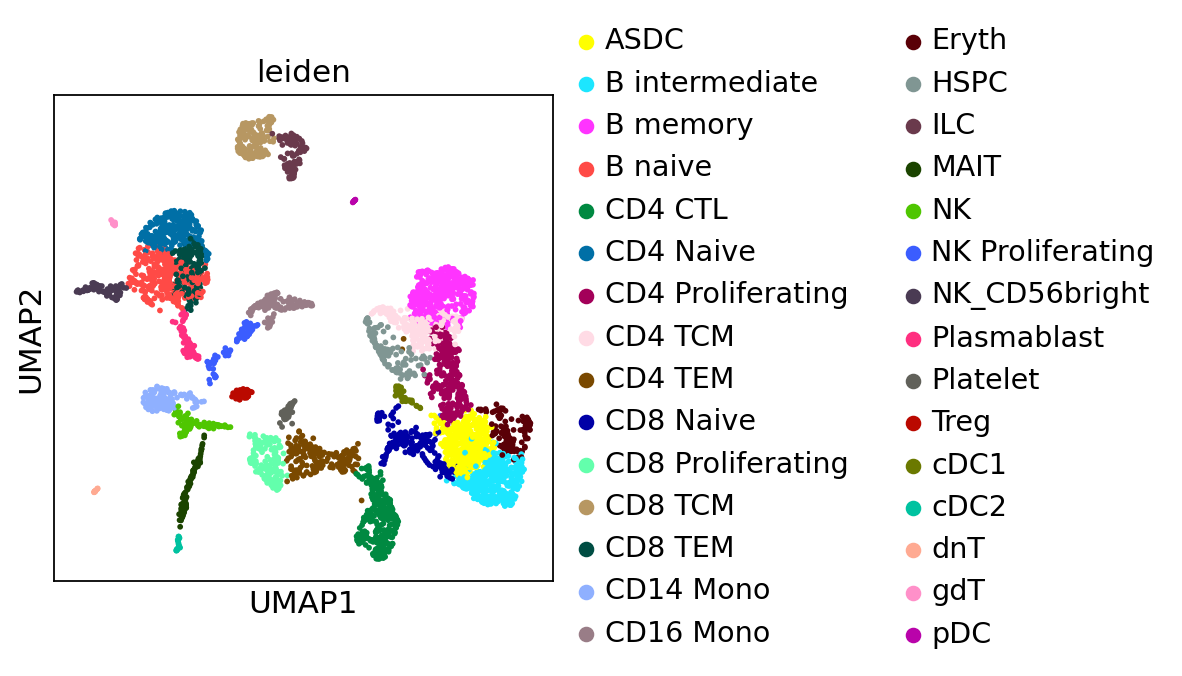

In [19]:
sc.pp.neighbors(imputed_Healthy_PBMC_protein)
resolution = 1.2
sc.tl.leiden(imputed_Healthy_PBMC_protein,resolution = resolution)
sc.tl.paga(imputed_Healthy_PBMC_protein)
sc.pl.paga(imputed_Healthy_PBMC_protein, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(imputed_Healthy_PBMC_protein, init_pos='paga')
new_cluster_names = imputed_Healthy_PBMC_protein.obs['transfered cell labels'].cat.categories
imputed_Healthy_PBMC_protein.rename_categories("leiden",new_cluster_names)
sc.pl.umap(imputed_Healthy_PBMC_protein, color=["leiden"])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)


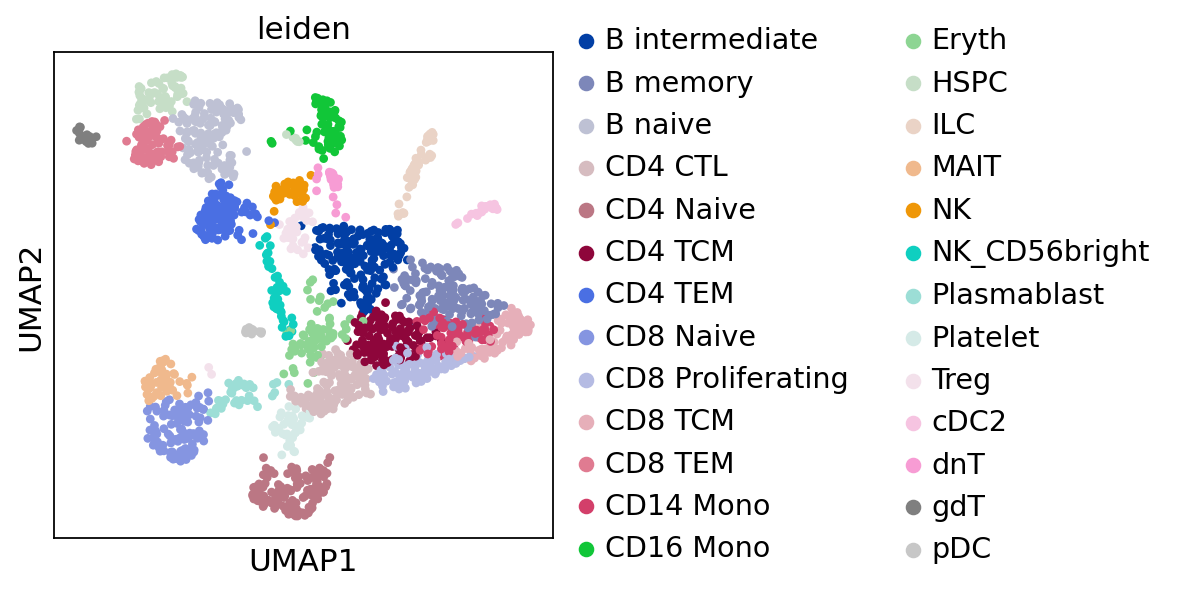

In [24]:
sc.pp.neighbors(imputed_AML_protein)
resolution = 1.7000000000000004
sc.tl.leiden(imputed_AML_protein,resolution = resolution)
sc.tl.paga(imputed_AML_protein)
sc.pl.paga(imputed_AML_protein, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(imputed_AML_protein, init_pos='paga')
new_cluster_AML_names = imputed_AML_protein.obs['transfered cell labels'].cat.categories
imputed_AML_protein.rename_categories("leiden",new_cluster_AML_names)
sc.pl.umap(imputed_AML_protein, color=["leiden"])

In [22]:


def leiden_with_n_clusters(adata, n_clusters, resolution_range=(1.2,2), max_iterations=100):
    for resolution in np.arange(resolution_range[0], resolution_range[1], 0.1):
        sc.tl.leiden(adata, resolution=resolution, key_added='leiden_temp', random_state=0)
        if len(np.unique(adata.obs['leiden_temp'])) == n_clusters:
            adata.obs['leiden'] = adata.obs['leiden_temp']
            del adata.obs['leiden_temp']
            return resolution
    
    raise ValueError(f"Could not find {n_clusters} clusters within the given resolution range")

# Assuming you have your AnnData object 'adata' ready
adata = imputed_AML_protein
optimal_resolution = leiden_with_n_clusters(adata, n_clusters=26)
print(f"Optimal resolution for 26 clusters: {optimal_resolution}")

running Leiden clustering
    finished: found 21 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden_temp', the cluster labels (adata.obs, categorical) (0:00:00)
Optimal resolution for 26 clusters: 1.7000000000000004


computing neighbors
computing PCA
    with n_comps=50


/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 224 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)
running Leiden clustering


/tmp/ipykernel_56445/634575446.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(imputed_AML_protein,resolution = resolution)


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


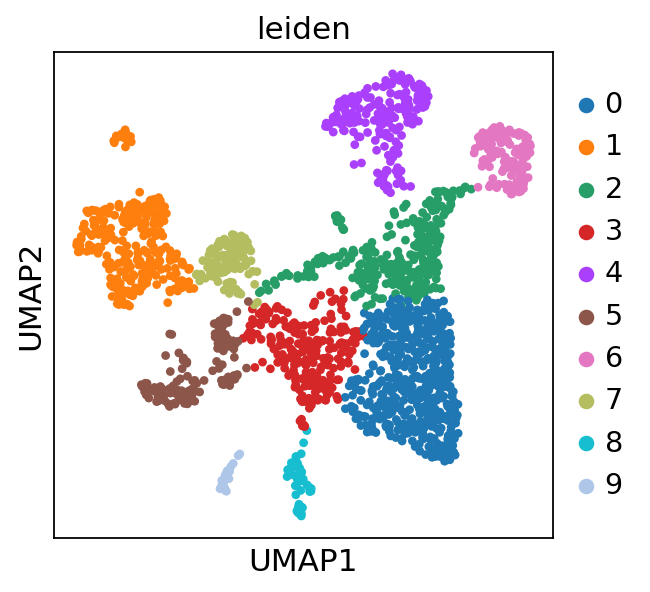

In [17]:
sc.pp.neighbors(imputed_AML_protein)
resolution = 0.2
sc.tl.leiden(imputed_AML_protein,resolution = resolution)
sc.tl.paga(imputed_AML_protein)
sc.pl.paga(imputed_AML_protein, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(imputed_AML_protein, init_pos='paga')
sc.pl.umap(imputed_AML_protein, color=["leiden"])

In [ ]:
adata_imputed_proteins_common

In [ ]:
adata_imputed_proteins_common.obs

In [ ]:
np.random.seed(42)
selected_indices_imputed = np.random.choice(adata_imputed_proteins_common.n_obs, 5611, replace=False)
test_imputed = adata_imputed_proteins_common[selected_indices_imputed, :]

selected_indices_true = np.random.choice(adata_true_proteins_common.n_obs, 5611, replace=False)
test_true = adata_true_proteins_common[selected_indices_true, :]

In [ ]:
test_imputed = Testing_data_protein
sc.pp.normalize_total(test_imputed)

sc.pp.log1p(test_imputed)


In [ ]:
test_imputed.to_df().values

In [ ]:
# Train Dataset
Selected_Train_Imputed = adata_imputed_proteins_common.obs_names.difference(test_true.obs_names)
Train_Imputed = adata_imputed_proteins_common[adata_imputed_proteins_common.obs_names.isin(Selected_Train_Imputed), :]

# Test Dataset
Selected_Train_True= adata_true_proteins_common.obs_names.difference(test_true.obs_names)
Train_True = adata_true_proteins_common[adata_true_proteins_common.obs_names.isin(Selected_Train_True), :]

In [ ]:
# Train Dataset
Train_Imputed = adata_imputed_proteins_common

# Test Dataset
Train_True = adata_true_proteins_common

FeedForward Network to Train Model on ADT clustering

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import mlflow

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Convert numpy array to tensor
        data = torch.from_numpy(self.data[idx]).float()
        label = torch.tensor(self.labels[idx]).long()
        return data, label

class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size_1, output_size)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.fc4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Example usage:
input_size = Train_Imputed.X.shape[1]  # Get input size from data
hidden_size_1 = 2^10
hidden_size_2 = 2^12
hidden_size_3 = 2^12
output_size = len(np.unique(Train_True.obs['leiden']))

# Create dataset
data = Train_Imputed.X
labels = Train_True.obs['leiden'].values

# Convert labels to numeric format if they're not already
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_to_index[label] for label in labels])

dataset = CustomDataset(data, numeric_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model, loss, and optimizer
model = FeedForwardNet(input_size, hidden_size, output_size)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(1000):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        # Move data and labels to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/1000], Average Loss: {avg_loss:.4f}')

    # Save the model
torch.save(model.state_dict(), 'feedforward_model.pth')
print("Model saved successfully!")

# To save additional information (optional)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, 'feedforward_model_checkpoint.pth')
print("Model checkpoint saved successfully!")

In [ ]:
# Load the checkpoint
checkpoint = torch.load('feedforward_model_checkpoint.pth')

# Initialize the model
model = FeedForwardNet(input_size, hidden_size, output_size)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# If you want to resume training, you can also load the optimizer state
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Model checkpoint loaded successfully! Epoch: {epoch}, Loss: {loss:.4f}")

# Set the model to evaluation mode if you're doing inference
model.eval()

# Or set it to training mode if you're resuming training
# model.train()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Predicitons Feedforward

In [ ]:
# Assuming you have some new data to predict on
new_data = torch.tensor(test_imputed.to_df().values).float().to(device)

with torch.no_grad():
    outputs = model(new_data)
    _, predicted = torch.max(outputs, 1)

print("Predictions:", predicted)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import mlflow

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Convert numpy array to tensor
        data = torch.from_numpy(self.data[idx]).float()
        label = torch.tensor(self.labels[idx]).long()
        return data, label

# Advanced FeedForward Network
class AdvancedFeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5):
        super(AdvancedFeedForwardNet, self).__init__()
        
        # First layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])  # Batch Normalization
        
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])  # Batch Normalization
        
        # Third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])  # Batch Normalization
        
        # Output layer
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # First layer with ReLU, BatchNorm, and Dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        # Second layer with ReLU, BatchNorm, and Dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        # Third layer with ReLU, BatchNorm, and Dropout
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        # Output layer (no activation for output, assuming CrossEntropyLoss)
        x = self.fc4(x)
        return x

#Usage
input_size = Train_Imputed.X.shape[1]  # Get input size from data
hidden_sizes = [1024, 256, 128]  # Define hidden layer sizes
output_size = len(np.unique(Train_True.obs['leiden']))  # Output size is number of classes
dropout_rate = 0.5  # Dropout rate

# Create dataset
data = Train_Imputed.X
labels = Train_True.obs['leiden'].values

# Convert labels to numeric format if they're not already
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_to_index[label] for label in labels])

dataset = CustomDataset(data, numeric_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the advanced model, loss function, and optimizer
model = AdvancedFeedForwardNet(input_size, hidden_sizes, output_size, dropout_rate)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(2000):
    total_loss = 0
    model.train()  # Set model to training mode
    for batch_data, batch_labels in dataloader:
        # Move data and labels to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients from the previous iteration
        outputs = model(batch_data)  # Forward pass through the network
        loss = criterion(outputs, batch_labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/2000], Average Loss: {avg_loss:.4f}')

    # Optionally, you can save the model at regular intervals or based on performance
    if (epoch + 1) % 500 == 0:  # Save checkpoint every 100 epochs
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'advanced_feedforward_model_checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}")

# Save the final model after training
torch.save(model.state_dict(), 'advanced_feedforward_model.pth')
print("Final model saved successfully!")


Predictions Advanced Feedforward

In [ ]:
# Load the checkpoint
checkpoint = torch.load('advanced_feedforward_model_checkpoint_epoch_1000.pth')

# Initialize the AdvancedFeedForwardNet model
input_size = Train_Imputed.X.shape[1]  # Get input size from data
hidden_sizes = [256, 128, 64]  # Use the same hidden sizes that were used in training
output_size = len(np.unique(Train_True.obs['leiden']))  # Number of classes
dropout_rate = 0.5  # Dropout rate

model = AdvancedFeedForwardNet(input_size, hidden_sizes, output_size, dropout_rate)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# If you want to resume training, you can also load the optimizer state
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Model checkpoint loaded successfully! Epoch: {epoch}, Loss: {loss:.4f}")

# Set the model to evaluation mode for inference
model.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prediction function
def predict(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for batch_data, _ in dataloader:  # Assuming you only need data for predictions
            batch_data = batch_data.to(device)  # Move data to device (GPU/CPU)
            outputs = model(batch_data)  # Forward pass
            _, predicted_labels = torch.max(outputs, 1)  # Get predicted labels
            predictions.extend(predicted_labels.cpu().numpy())  # Move predictions to CPU and store them
    return np.array(predictions)

# Example usage for predictions
# Assuming you have a separate test set or unseen data in a similar format as training data
test_data = test_imputed.X  # Replace with your actual test data
test_labels = test_true.obs['leiden'].values.codes  # Replace with true labels if available

# Create a test dataset and dataloader
test_dataset = CustomDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Predict labels using the trained model
Aff_predicted_labels = predict(model, test_dataloader, device)

# Print or use the predicted labels
print("Predictions:", Aff_predicted_labels)


In [ ]:
# Import the necessary classes from the model.py inside the models directory
from model import VGAE, GAE

# Other necessary imports
import torch
import numpy as np

# Example usage
if __name__ == "__main__":
    # Define your parameters (adjust according to your setup)
    input_dim = Train_Imputed.X.shape[1]  # Number of features (e.g., number of cell surface protein markers)
    hidden1_dim = 64  # Size of the first hidden layer
    hidden2_dim = 32  # Size of the second hidden layer (latent space dimension)
    n_clusters = 5  # Number of clusters in the output
    adj = torch.eye(input_dim)  # Example adjacency matrix (replace with your graph structure)

    # Generate some random input data (for example, cell surface protein marker data)
    X = torch.rand((input_dim, input_dim))  # Replace with your actual data

    # Initialize the VGAE model with the correct parameters
    model = VGAE(input_dim=input_dim, hidden1_dim=hidden1_dim, hidden2_dim=hidden2_dim, adj=adj, n_clusters=n_clusters)

    # Forward pass to get the reconstructed adjacency matrix and cluster labels
    A_pred, cluster_labels = model(X)

    # Print the predicted cluster labels
    print("Cluster Labels: ", cluster_labels)

    # Print the reconstructed adjacency matrix
    print("Reconstructed Adjacency Matrix: ", A_pred)


In [ ]:
test_labels.codes

In [ ]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Ensure that both AnnData objects have the Leiden clustering labels
true_labels = test_true.obs['leiden'].to_numpy().astype(int)
predicted_labels = predicted.cpu().numpy()

#predicted_labels = Aff_predicted_labels

# Optionally, you can visualize the clustering agreement using a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Clusters')
plt.ylabel('True Clusters')
plt.title('CM of Leiden Clustering on Train_Data (SimpFF Model with ValAcc = 0.3)')
plt.show()

def calculate_accuracy(conf_matrix):
    # Sum of diagonal elements (True Positives)
    diagonal_sum = np.trace(conf_matrix)
    
    # Total sum of all elements in the confusion matrix
    total_sum = np.sum(conf_matrix)
    
    # Accuracy formula
    accuracy = diagonal_sum / total_sum
    return accuracy

# Get the accuracy
accuracy = calculate_accuracy(conf_matrix)

print(f"Accuracy: {accuracy:.4f}")


In [ ]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata_true_proteins_common, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_true_proteins_common, n_genes=20, sharey=False)


In [ ]:
result = adata_true_proteins_common.uns['rank_genes_groups']

# Get the names of the clusters
groups = result['names'].dtype.names

# Create a dictionary to store highly expressed genes for each cluster
highly_expressed_genes = {group: result['names'][group] for group in groups}

# Convert the results to a DataFrame for better visualization
df_genes = pd.DataFrame(highly_expressed_genes)

df_genes



In [ ]:
true_labels